In [60]:
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import pandas as pd
import requests
import csv
import torch
from torchvision import models, transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [ ]:
class KaggleParser:
    def __init__(self):
        self.url = "https://www.kaggle.com/datasets/neetuk/naruto-face-dataset/"
        self.options = Options()
        self.options.add_argument("window-size=1920,1080")
        self.service = Service(ChromeDriverManager().install())

    def click_initial_button(self, driver):
        try:
            print("Ищу начальную кнопку...")
            initial_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH,
                                            "//*[@id='site-content']/div[2]/div/div[2]/div/div[5]/div[2]/div/div/div[1]/div/div[3]/div/div[1]"))
            )
            initial_button.click()
            print("Клик по начальной кнопке выполнен.")
            time.sleep(2)
        except Exception as e:
            print(f"Ошибка при клике на начальную кнопку: {e}")

    def get_image_urls(self, driver):
        image_urls = []

        while True:
            try:
                page_source = driver.page_source
                soup = BeautifulSoup(page_source, "lxml")

                container = soup.find('div', class_='sc-coBSru fzXizf')
                if container:
                    images = container.find_all('img', class_='sc-gkdOxF jeCaKc')
                    for img in images:
                        image_url = img.get('src')
                        if image_url and image_url not in image_urls:
                            image_urls.append(image_url)

                print(f"Найдено {len(images)} изображений, всего собрано {len(image_urls)} уникальных ссылок.")

                try:
                    load_more_button = WebDriverWait(driver, 10).until(
                        EC.element_to_be_clickable((By.XPATH, "//a[@class='sc-kxwyJt ioojjQ']"))
                    )
                    driver.execute_script("arguments[0].click();", load_more_button)
                    print("Кнопка 'Load more' нажата.")
                    time.sleep(2)
                except Exception as e:
                    print("Кнопка 'Load more' отсутствует. Завершаем обработку.")
                    break

            except Exception as e:
                print(f"Ошибка при обработке страницы: {e}")
                break

        return image_urls

    def save_to_csv(self, data, filename="kaggle_data.csv"):
        with open(filename, "w", newline="", encoding="utf-8") as file:
            writer = csv.writer(file)
            writer.writerow(["Image URL"])
            for url in data:
                writer.writerow([url])

if __name__ == "__main__":
    parser = KaggleParser()
    try:
        with webdriver.Chrome(service=parser.service, options=parser.options) as driver:
            driver.get(parser.url)
            time.sleep(2)

            parser.click_initial_button(driver)

            image_urls = parser.get_image_urls(driver)

            parser.save_to_csv(image_urls)
            print(f"Данные сохранены в файл kaggle_data.csv")
    except Exception as e:
        print(f"Ошибка при запуске браузера: {e}")

In [ ]:
df = pd.read_csv("kaggle_data.csv")
df.head()

In [ ]:
def download_images(csv_file, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader) 
        for idx, row in enumerate(reader):
            image_url = row[0]
            try:
                response = requests.get(image_url, stream=True)
                response.raise_for_status()

                filename = os.path.join(output_folder, f'image_{idx}.jpg')

                with open(filename, 'wb') as img_file:
                    for chunk in response.iter_content(1024):
                        img_file.write(chunk)

                print(f"Изображение сохранено: {filename}")
            except Exception as e:
                print(f"Ошибка при загрузке {image_url}: {e}")


csv_file = 'kaggle_data.csv'
output_folder = 'images'

download_images(csv_file, output_folder)

# конвертировал напаршенное в папку с картинками

In [20]:
df = pd.read_csv("data_from_label_studio.csv")
df.head()

# думал что за меня круто все разметит label-studio, но в итоге убил несколько часов на то чтобы понять, что вручную все размечается куда быстрее

,annotation_id,annotator,character_class,created_at,id,image,lead_time,updated_at
0,2,1,Naruto,2025-01-14T16:29:07.481469Z,101,/data/upload/2/d10895cc-image_91.jpg,8.564,2025-01-14T16:29:07.481469Z
1,3,1,Naruto,2025-01-14T16:29:11.344509Z,102,/data/upload/2/abb6a79f-image_92.jpg,3.628,2025-01-14T16:29:11.344509Z
2,4,1,Naruto,2025-01-14T16:29:16.101882Z,103,/data/upload/2/a00b64bc-image_93.jpg,4.536,2025-01-14T16:29:16.101882Z
3,5,1,Naruto,2025-01-14T16:29:20.898250Z,104,/data/upload/2/eea3b578-image_94.jpg,4.575,2025-01-14T16:29:20.898250Z
4,6,1,Naruto,2025-01-14T16:29:24.962789Z,105,/data/upload/2/8adcbde2-image_95.jpg,3.835,2025-01-14T16:29:24.962789Z


In [21]:
def convert_csv(input_file, output_file):
    df = pd.read_csv(input_file)

    df = df[['character_class', 'image']]

    df['image'] = df['image'].apply(
        lambda x: os.path.join(
            "C:\\Users\\Ivan\\PycharmProjects\\image-ekukovenko\\images",
            x.split("/")[-1].split("-", 1)[-1]
        )
    )

    df.to_csv(output_file, index=False)

input_file = 'data_from_label_studio.csv' 
output_file = 'output.csv'

convert_csv(input_file, output_file)

print(f"Conversion complete! The new CSV is saved as {output_file}")

Conversion complete! The new CSV is saved as output.csv


In [22]:
df = pd.read_csv("output.csv")
df.head()

# конвертировал частично-размеченный датасет по новой после этого интересного и увлекательного label-studio (видимо я не понял как им пользоваться)

,character_class,image
0,Naruto,C:\Users\Ivan\PycharmProjects\image-ekukovenko...
1,Naruto,C:\Users\Ivan\PycharmProjects\image-ekukovenko...
2,Naruto,C:\Users\Ivan\PycharmProjects\image-ekukovenko...
3,Naruto,C:\Users\Ivan\PycharmProjects\image-ekukovenko...
4,Naruto,C:\Users\Ivan\PycharmProjects\image-ekukovenko...


In [23]:
from IPython.display import Image, display

def display_image(index, dataframe):
        row = dataframe.iloc[index]
        image_path = row["image"]
        character_class = row["character_class"]
        print(f"Index: {index}, Character Class: {character_class}")
        display(Image(filename=image_path))

Index: 52, Character Class: Sakura


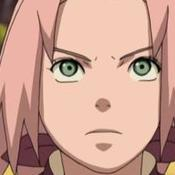

In [24]:
display_image(52, df)

In [25]:
labeled_csv = 'output.csv'
unlabeled_folder = 'C:/Users/Ivan/PycharmProjects/image-ekukovenko/images' 
output_csv = 'labeled_data.csv'

In [26]:
labeled_data = pd.read_csv(labeled_csv)

In [27]:
class_names = labeled_data['character_class'].unique().tolist()
class_names

['Naruto',
 'Sakura',
 'Tsunade',
 'Sasuke',
 'Gaara',
 'Shikamaru',
 'Kankurо',
 'Iruka',
 'Teuchi(ramen)',
 'Ayame(ramen)',
 'Ino',
 'Temari',
 'Yamato',
 "Ebizou(Chie's brother)",
 'Grandmother Chie',
 'Rokku Ri',
 'Shizune',
 'Ten-Ten']

In [28]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image']
        label = class_names.index(row['character_class']) 
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_dataset = ImageDataset(labeled_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
from torchvision.models import ResNet50_Weights

model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [ ]:
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

In [ ]:
torch.save(model.state_dict(), 'resnet_model_for_markup.pth')

In [ ]:
results = []

model.eval()
with torch.no_grad():
    for image_name in os.listdir(unlabeled_folder):
        image_path = os.path.join(unlabeled_folder, image_name)
        try:
            image = Image.open(image_path).convert('RGB')
            input_tensor = transform(image).unsqueeze(0).to(device)

            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            predicted_class = class_names[predicted.item()]

            results.append({
                'character_class': predicted_class,
                'image': image_path
            })
        except Exception as e:
            print(f"Ошибка при обработке {image_name}: {e}")

In [ ]:
predicted_data = pd.DataFrame(results)
predicted_data.to_csv('resnet_dataset.csv', index=False)

In [ ]:
from IPython.display import Image, display

In [29]:
df = pd.read_csv("resnet_dataset.csv")
df.head()

# разметилось очень коряво, поэтому после разметки реснетом все вручную проверил и исправил

,character_class,image
0,Sakura,C:/Users/Ivan/PycharmProjects/image-ekukovenko...
1,Sakura,C:/Users/Ivan/PycharmProjects/image-ekukovenko...
2,Sakura,C:/Users/Ivan/PycharmProjects/image-ekukovenko...
3,Naruto,C:/Users/Ivan/PycharmProjects/image-ekukovenko...
4,Sasuke,C:/Users/Ivan/PycharmProjects/image-ekukovenko...


Index: 6, Character Class: Sasuke


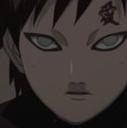

In [30]:
display_image(6, df)

# пример ошибки

In [31]:
df_correct = pd.read_csv("correct_dataset.csv")
df_correct.head()

,character_class,image
0,Sakura,C:/Users/Ivan/PycharmProjects/image-ekukovenko...
1,Sakura,C:/Users/Ivan/PycharmProjects/image-ekukovenko...
2,Sakura,C:/Users/Ivan/PycharmProjects/image-ekukovenko...
3,Naruto,C:/Users/Ivan/PycharmProjects/image-ekukovenko...
4,Gaara,C:/Users/Ivan/PycharmProjects/image-ekukovenko...


Index: 6, Character Class: Gaara


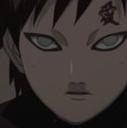

In [32]:
display_image(6, df_correct)

# пример исправления

In [33]:
def calculate_accuracy(predicted_csv, correct_csv):
    predicted_df = pd.read_csv(predicted_csv)
    correct_df = pd.read_csv(correct_csv)

    correct_predictions = sum(
        predicted_df['character_class'] == correct_df['character_class']
    )
    total_predictions = len(correct_df)
    accuracy = correct_predictions / total_predictions * 100

    print(f"Точность модели: {accuracy:.2f}%")
    print(f"Количество ошибок: {total_predictions - correct_predictions} из {total_predictions}")


In [34]:
calculate_accuracy("resnet_dataset.csv", "correct_dataset.csv")

Точность модели: 73.56%
Количество ошибок: 736 из 2784


In [73]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import pandas as pd
import os

In [74]:
labeled_csv = 'correct_dataset.csv'
df = pd.read_csv(labeled_csv)

In [75]:
class_counts = df['character_class'].value_counts()
print(class_counts)

character_class
Sakura                    882
Naruto                    356
Gaara                     283
Tsunade                   248
Grandmother Chie          194
Shikamaru                 170
Iruka                     158
Kankuro                   154
Sasuke                     97
Temari                     86
Ebizou(Chie's brother)     57
Teuchi(ramen)              26
Rokku Ri                   20
Yamato                     10
Shizune                    10
Ayame(ramen)               10
Hinata                      9
Ten-Ten                     8
Ino                         6
Name: count, dtype: int64


In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    df['image'], df['character_class'], test_size=0.2, random_state=42, stratify=df['character_class']
)

print(f"Обучающая выборка: {len(X_train)}, Тестовая выборка: {len(X_test)}")

Обучающая выборка: 2227, Тестовая выборка: 557


In [77]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [78]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths.iloc[idx]
        label = self.labels.iloc[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, class_names.index(label)

In [79]:
class_names = sorted(df['character_class'].unique().tolist())
class_names

['Ayame(ramen)',
 "Ebizou(Chie's brother)",
 'Gaara',
 'Grandmother Chie',
 'Hinata',
 'Ino',
 'Iruka',
 'Kankuro',
 'Naruto',
 'Rokku Ri',
 'Sakura',
 'Sasuke',
 'Shikamaru',
 'Shizune',
 'Temari',
 'Ten-Ten',
 'Teuchi(ramen)',
 'Tsunade',
 'Yamato']

In [80]:
train_dataset = ImageDataset(X_train, y_train, transform=transform)
test_dataset = ImageDataset(X_test, y_test, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [81]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),  
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),  
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(256, 512, kernel_size=8, stride=1, padding=0),  
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),  
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(256, num_classes)  
        )

    def forward(self, x, return_embedding=False):
        x = self.conv_layers(x)
        if return_embedding:
            return x
        x = self.fc_layers(x)
        return x


In [82]:
num_classes = len(class_names)

In [83]:
model = CustomCNN(num_classes)
model = model.to(device)
print(model)

CustomCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track

In [84]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
writer = SummaryWriter()

In [85]:
num_epochs = 30
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
writer = SummaryWriter()

start_time_my_model = time.time()

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    test_loss /= len(test_loader)
    test_accuracy = correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('Accuracy/Test', test_accuracy, epoch)

    print(f'Epoch [{epoch}/{num_epochs}] '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')
    
end_time_my_model = time.time()

writer.close()
torch.save(model.state_dict(), 'custom_cnn_model.pth')

Epoch [1/30] Train Loss: 1.0782, Train Acc: 0.7036 | Test Loss: 0.3889, Test Acc: 0.8815
Epoch [2/30] Train Loss: 0.3678, Train Acc: 0.9003 | Test Loss: 0.2382, Test Acc: 0.9210
Epoch [3/30] Train Loss: 0.2570, Train Acc: 0.9219 | Test Loss: 0.1373, Test Acc: 0.9695
Epoch [4/30] Train Loss: 0.1697, Train Acc: 0.9551 | Test Loss: 0.1279, Test Acc: 0.9605
Epoch [5/30] Train Loss: 0.1231, Train Acc: 0.9659 | Test Loss: 0.1373, Test Acc: 0.9641
Epoch [6/30] Train Loss: 0.0994, Train Acc: 0.9731 | Test Loss: 0.0910, Test Acc: 0.9820
Epoch [7/30] Train Loss: 0.0705, Train Acc: 0.9802 | Test Loss: 0.0967, Test Acc: 0.9785
Epoch [8/30] Train Loss: 0.0941, Train Acc: 0.9722 | Test Loss: 0.1269, Test Acc: 0.9803
Epoch [9/30] Train Loss: 0.0797, Train Acc: 0.9793 | Test Loss: 0.1289, Test Acc: 0.9659
Epoch [10/30] Train Loss: 0.1128, Train Acc: 0.9713 | Test Loss: 0.1758, Test Acc: 0.9695
Epoch [11/30] Train Loss: 0.0999, Train Acc: 0.9677 | Test Loss: 0.1368, Test Acc: 0.9749
Epoch [12/30] Train

In [86]:
print(end_time_my_model - start_time_my_model)

# 5 минут

315.19393014907837


In [87]:
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

print(classification_report(all_targets, all_preds, target_names=class_names))

                        precision    recall  f1-score   support

          Ayame(ramen)       1.00      1.00      1.00         2
Ebizou(Chie's brother)       1.00      1.00      1.00        11
                 Gaara       1.00      0.98      0.99        57
      Grandmother Chie       1.00      1.00      1.00        39
                Hinata       1.00      1.00      1.00         2
                   Ino       0.00      0.00      0.00         1
                 Iruka       0.97      1.00      0.98        32
               Kankuro       0.97      1.00      0.98        31
                Naruto       0.96      0.96      0.96        71
              Rokku Ri       1.00      1.00      1.00         4
                Sakura       0.99      0.97      0.98       176
                Sasuke       0.94      0.89      0.92        19
             Shikamaru       0.89      1.00      0.94        34
               Shizune       1.00      1.00      1.00         2
                Temari       1.00      

C:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [88]:
import numpy as np

model.eval()
embeddings, labels = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        embedding = model(inputs, return_embedding=True)
        embeddings.append(embedding.cpu().numpy())
        labels.extend(targets.cpu().numpy())
        
embeddings = np.concatenate(embeddings, axis=0)
labels = np.array(labels)

In [89]:
if len(embeddings.shape) == 4:
    batch_size, channels, height, width = embeddings.shape
    embeddings = embeddings.reshape(batch_size, -1)

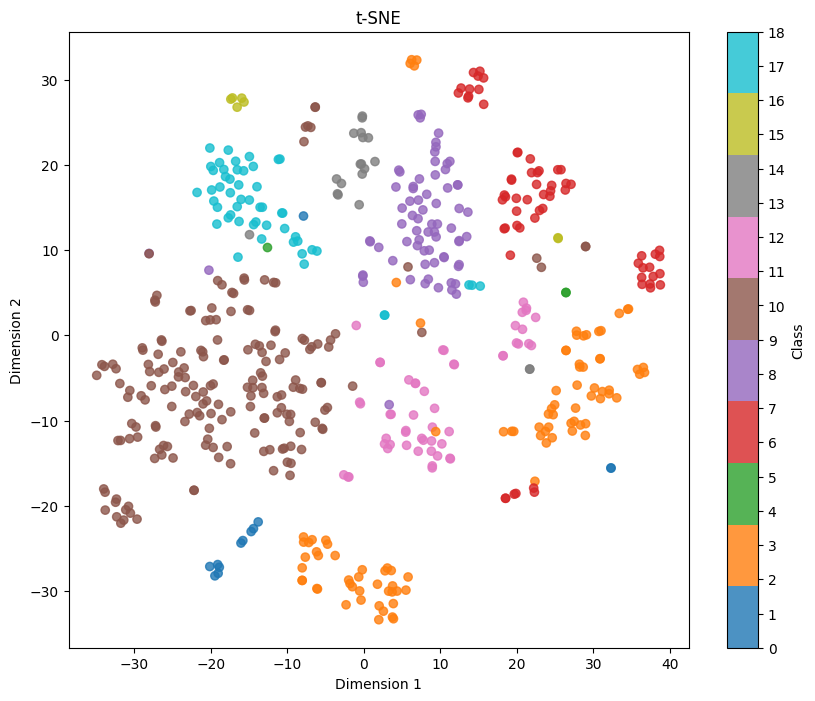

In [90]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels, cmap='tab10', alpha=0.8)
plt.colorbar(scatter, ticks=range(len(class_names)), label='Class')
plt.title("t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [91]:
# дообучу свой старый реснет

class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.base_model = models.resnet50(weights=None)
        self.num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()
        self.fc = nn.Linear(self.num_features, num_classes)
    
    def forward(self, x, return_embedding=False):
        features = self.base_model(x)
        if return_embedding:
            return features
        x = self.fc(features)
        return x

In [92]:
model = ResNet(num_classes)
checkpoint = torch.load("resnet_model_for_markup.pth")
filtered_checkpoint = {k: v for k, v in checkpoint.items() if "fc" not in k}
model.load_state_dict(filtered_checkpoint, strict=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)


C:\Users\Ivan\AppData\Local\Temp\ipykernel_15096\2114162890.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("resnet_model_for_markup.pth")


Using device: cuda


In [93]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [94]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [95]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths.iloc[idx]
        label = self.labels.iloc[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, class_names.index(label)

In [96]:
train_dataset = ImageDataset(X_train, y_train, transform=transform)
test_dataset = ImageDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [97]:
num_epochs = 30
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
writer_resnet = SummaryWriter()

start_time_resnet = time.time()

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    test_loss /= len(test_loader)
    test_accuracy = correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    writer_resnet.add_scalar('Loss/Train', train_loss, epoch)
    writer_resnet.add_scalar('Accuracy/Train', train_accuracy, epoch)
    writer_resnet.add_scalar('Loss/Test', test_loss, epoch)
    writer_resnet.add_scalar('Accuracy/Test', test_accuracy, epoch)

    print(f'Epoch [{epoch}/{num_epochs}] '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')
    
end_time_resnet = time.time()

writer_resnet.close()
torch.save(model.state_dict(), 'resnet_main_model.pth')

Epoch [1/30] Train Loss: 1.6867, Train Acc: 0.4755 | Test Loss: 1.7417, Test Acc: 0.4919
Epoch [2/30] Train Loss: 0.6890, Train Acc: 0.8159 | Test Loss: 0.7310, Test Acc: 0.7487
Epoch [3/30] Train Loss: 0.3534, Train Acc: 0.9070 | Test Loss: 0.4248, Test Acc: 0.8671
Epoch [4/30] Train Loss: 0.1971, Train Acc: 0.9529 | Test Loss: 0.3715, Test Acc: 0.8995
Epoch [5/30] Train Loss: 0.1412, Train Acc: 0.9659 | Test Loss: 0.2063, Test Acc: 0.9497
Epoch [6/30] Train Loss: 0.1183, Train Acc: 0.9740 | Test Loss: 0.2765, Test Acc: 0.9031
Epoch [7/30] Train Loss: 0.1181, Train Acc: 0.9690 | Test Loss: 0.7922, Test Acc: 0.8205
Epoch [8/30] Train Loss: 0.0895, Train Acc: 0.9780 | Test Loss: 0.6416, Test Acc: 0.8348
Epoch [9/30] Train Loss: 0.0763, Train Acc: 0.9780 | Test Loss: 0.2156, Test Acc: 0.9497
Epoch [10/30] Train Loss: 0.0592, Train Acc: 0.9843 | Test Loss: 0.2173, Test Acc: 0.9318
Epoch [11/30] Train Loss: 0.0469, Train Acc: 0.9892 | Test Loss: 0.2268, Test Acc: 0.9425
Epoch [12/30] Train

In [99]:
print(end_time_resnet - start_time_resnet)

# почти 15 минут - это в три раза дольше чем моя модель

849.4626924991608


In [98]:
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

print(classification_report(all_targets, all_preds, target_names=class_names))

                        precision    recall  f1-score   support

          Ayame(ramen)       1.00      1.00      1.00         2
Ebizou(Chie's brother)       1.00      1.00      1.00        11
                 Gaara       0.96      0.96      0.96        57
      Grandmother Chie       1.00      1.00      1.00        39
                Hinata       0.00      0.00      0.00         2
                   Ino       0.00      0.00      0.00         1
                 Iruka       1.00      1.00      1.00        32
               Kankuro       1.00      1.00      1.00        31
                Naruto       0.97      0.99      0.98        71
              Rokku Ri       1.00      1.00      1.00         4
                Sakura       0.99      0.95      0.97       176
                Sasuke       0.86      1.00      0.93        19
             Shikamaru       0.89      1.00      0.94        34
               Shizune       1.00      1.00      1.00         2
                Temari       1.00      

C:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [100]:
import numpy as np

model.eval()
embeddings, labels = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        embedding = model(inputs, return_embedding=True)
        embeddings.append(embedding.cpu().numpy())
        labels.extend(targets.cpu().numpy())
        
embeddings = np.concatenate(embeddings, axis=0)
labels = np.array(labels)

In [101]:
if len(embeddings.shape) == 4:
    batch_size, channels, height, width = embeddings.shape
    embeddings = embeddings.reshape(batch_size, -1)

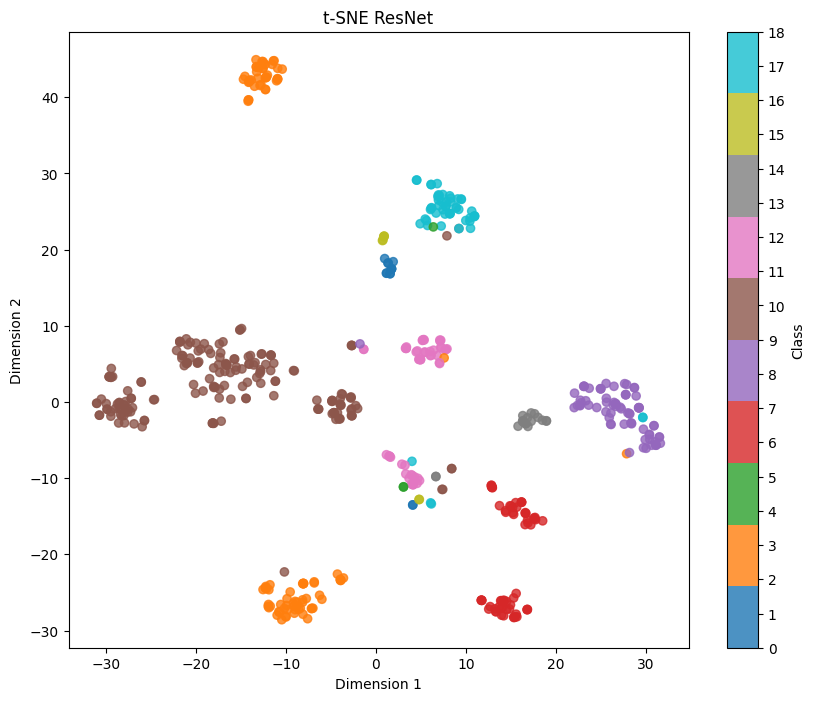

In [102]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels, cmap='tab10', alpha=0.8)
plt.colorbar(scatter, ticks=range(len(class_names)), label='Class')
plt.title("t-SNE ResNet")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()